In [0]:
#@title Mount Google drive { display-mode: "form" }
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# @title  Install Required Libs
# install keras
print("Installing Keras")
!pip install -q keras
import keras

# Install pydot for visivilizing the network into image
print("Installing pydot")
!pip install -q pydot

Installing Keras


Using TensorFlow backend.


Installing pydot


In [0]:
# @title Download data from remote repo and unzip it
%matplotlib  inline
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'

--2019-04-07 06:48:33--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  38.8MB/s    in 7.5s    

2019-04-07 06:48:41 (31.7 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [0]:
# @title Import and Preprocess the validation dataset
# Import required libs and read data
import numpy as np
import pandas as pd

val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)


In [0]:
# @title Definition of CLR
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
# @title Import Required Libs
import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Lambda
)
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    GlobalAveragePooling2D,
    SeparableConv2D,
    Concatenate
)

from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.regularizers import l2

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping, ModelCheckpoint

import tensorflow as tf
from keras import backend as K

import matplotlib
from matplotlib import pyplot as plt

# this part will prevent tensorflow to allocate all the avaliable GPU Memory

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
# @title Set all Hyperparameters
batch_size = 128
epochs = 50
num_filter = 64
compression = 0.5
dropout_rate = 0.0
layers = [12, 12, 12, 12]
# layers = [40,40,40,40]
steps_per_epoch = 1000
nb_classes = 200

model_path = '/content/gdrive/My Drive/models/densenet/try_3/'

print("Model Output Path", model_path)
print("batch_size", batch_size)
print("epochs", epochs)
print("num_filter", num_filter)
print("compression", compression)
print("dropout_rate", dropout_rate)
print("layers", layers)
print("steps_per_epoch", steps_per_epoch)
print("nb_classes", nb_classes)

Model Output Path /content/gdrive/My Drive/models/densenet/try_3/
batch_size 128
epochs 50
num_filter 64
compression 0.5
dropout_rate 0.0
layers [12, 12, 12, 12]
steps_per_epoch 1000
nb_classes 200


### Create Image Generator

In [0]:
# Create Image Generator
train_datagen = ImageDataGenerator(# rotation_range=30,
                                   rescale= 1./255,
                                   # width_shift_range=0.2,
                                   # height_shift_range=0.2,
                                   # shear_range=0.01,
                                   # zoom_range=[0.9, 1.25],
                                   # horizontal_flip=True,
                                   # vertical_flip=False,
                                   # fill_mode='reflect',
                                   # brightness_range=[0.5, 1.5]
)

valid_datagen = ImageDataGenerator(rescale=1./255)

### Initialize CLR

In [0]:
# Initialize CLR

base_lr = 0.001
max_lr = 0.01
step_size = 2000
scale_mode = 'cycle'

clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
clr = CyclicLR(base_lr=base_lr, max_lr=max_lr,
               step_size=step_size, scale_fn=clr_fn,
               scale_mode=scale_mode)

print("Clr Parameters")
print("LR Range", max_lr, " - ", base_lr)
print("Step Size", 2000)
print("Mode", scale_mode)

Clr Parameters
LR Range 0.01  -  0.001
Step Size 2000
Mode cycle


## Define Model

### Dense Net Building Blocks

In [0]:
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2, layers=12):
    global compression
    temp = input
    for _ in range(layers):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = SeparableConv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        temp = concat
        
    return temp

def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = SeparableConv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    reducer = SeparableConv2D(nb_classes, (1, 1), strides=(1, 1), padding='same', use_bias=False)(AvgPooling)
    flatten = GlobalAveragePooling2D()(reducer)
    output = Activation('softmax')(flatten)
#     flat = Flatten()(AvgPooling)
#     output = Dense(num_classes, activation='softmax')(flat)
    
    return output

### Build Model

In [0]:
input = Input(shape=(None, None, 3,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate, layers[0])
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate, layers[1])
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate, layers[2])
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate, layers[3])
output = output_layer(Last_Block)

model = Model(inputs=[input], outputs=[output])
model.summary()

from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 6 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 6 0           batch_normalization_1[0][0]      
_____________________________________

### Compile Network

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Train With Out Augumentation

### Train For 32x32 images

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
200/200 [==============================] - 184s 922ms/step - loss: 5.0996 - acc: 0.0172 - val_loss: 14.4262 - val_acc: 0.0051

Epoch 00001: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-32-01-0.01.hdf5
Epoch 2/50
200/200 [==============================] - 171s 856ms/step - loss: 4.6896 - acc: 0.0457 - val_loss: 6.1651 - val_acc: 0.0156

Epoch 00002: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-32-02-0.02.hdf5
Epoch 3/50
200/200 [==============================] - 171s 854ms/step - loss: 4.3742 - acc: 0.0752 - val_loss: 6.5347 - val_acc: 0.0359

Epoch 00003: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-32-03-0.04.hdf5
Epoch 4/50
200/200 [==============================] - 171s 853ms/step - loss: 4.0998 - acc: 0.1154 - val_lo

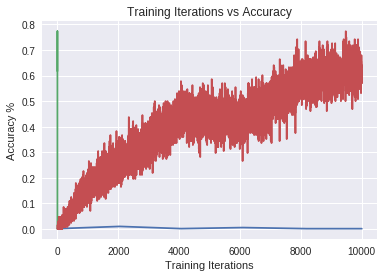

In [0]:
# image size 32x32: Fit the model on the batches generated by datagen.flow()

filepath_32 = model_path + "try-3-saved-model-woa-32-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint_32 = ModelCheckpoint(filepath_32, monitor='val_acc', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

train_generator_32 = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(32, 32), color_mode='rgb', 
                                                    batch_size=batch_size, class_mode='categorical', shuffle=True, seed=42)
validation_generator_32 = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(32, 32),
                                                    color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42)

model.fit_generator(train_generator_32,
                    steps_per_epoch=200,
                    validation_data=validation_generator_32,
                    validation_steps=20,
                    epochs=epochs, verbose=1,
                    callbacks=[clr, checkpoint_32])

model.save(model_path + 'try-3-saved-model-woa-32.h5')  # creates a HDF5 file

plt.rcParams["figure.figsize"] = (20, 5)

plt.subplot(1, 3, 1)
plt.plot(clr.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")

plt.subplot(1, 3, 2)
plt.plot(clr.history['iterations'], clr.history['acc'])
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy %')
plt.title("Training Iterations vs Accuracy")

plt.subplot(1, 3, 3)
plt.plot(clr.history['lr'], clr.history['acc'])
plt.xlabel('Learning Rate')
plt.ylabel('Training Accuracy')
plt.title("CLR - 'Custom' Policy lr to accuracy comparison")

plt.show()

### Train On 16*16

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/50
200/200 [==============================] - 65s 325ms/step - loss: 3.9410 - acc: 0.2228 - val_loss: 3.7192 - val_acc: 0.2293

Epoch 00001: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-16-01-0.23.hdf5
Epoch 2/50
200/200 [==============================] - 64s 320ms/step - loss: 3.3017 - acc: 0.2528 - val_loss: 3.5336 - val_acc: 0.2273

Epoch 00002: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-16-02-0.23.hdf5
Epoch 3/50
200/200 [==============================] - 63s 316ms/step - loss: 3.1324 - acc: 0.2746 - val_loss: 3.3876 - val_acc: 0.2492

Epoch 00003: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-16-03-0.25.hdf5
Epoch 4/50
200/200 [==============================] - 63s 315ms/step - loss: 3.0804 - acc: 0.2864 - val_loss: 3.2736 - val_acc: 0.2725

Epoch 00004: saving mod

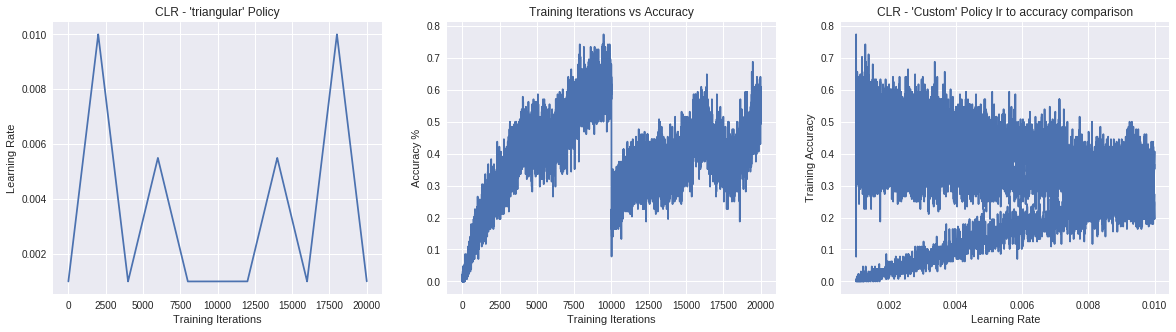

In [0]:
# image size 16x16: Fit the model on the batches generated by datagen.flow()

filepath_16 = model_path + "try-3-saved-model-woa-16-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint_16 = ModelCheckpoint(filepath_16, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

train_generator_16 = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(16, 16), color_mode='rgb', 
                                                    batch_size=batch_size, class_mode='categorical', shuffle=True, seed=42)
validation_generator_16 = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(16, 16),
                                                    color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42)

model.fit_generator(train_generator_16,
                    steps_per_epoch=200,
                    validation_data=validation_generator_16,
                    validation_steps=20,
                    epochs=epochs, verbose=1,
                    callbacks=[clr, checkpoint_16])

model.save(model_path + 'try-3-saved-model-woa-16.h5')  # creates a HDF5 file

plt.rcParams["figure.figsize"] = (20, 5)

plt.subplot(1, 3, 1)
plt.plot(clr.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")

plt.subplot(1, 3, 2)
plt.plot(clr.history['iterations'], clr.history['acc'])
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy %')
plt.title("Training Iterations vs Accuracy")

plt.subplot(1, 3, 3)
plt.plot(clr.history['lr'], clr.history['acc'])
plt.xlabel('Learning Rate')
plt.ylabel('Training Accuracy')
plt.title("CLR - 'Custom' Policy lr to accuracy comparison")

plt.show()

### Train on 64*64

In [0]:
# image size 64x64: Fit the model on the batches generated by datagen.flow()

batch_size = 32

train_generator_64 = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=batch_size, class_mode='categorical', shuffle=True, seed=42)
validation_generator_64 = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42)

filepath_64 = model_path + "try-3-saved-model-woa-64-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint_64 = ModelCheckpoint(filepath_64, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(train_generator_64,
                    steps_per_epoch=200,
                    validation_data=validation_generator_64,
                    validation_steps=40,
                    epochs=100, verbose=1,
                    callbacks=[clr, checkpoint_64])

model.save(model_path + 'try-3-saved-model-woa-64.h5')  # creates a HDF5 file

plt.rcParams["figure.figsize"] = (20, 5)

plt.subplot(1, 3, 1)
plt.plot(clr.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")

plt.subplot(1, 3, 2)
plt.plot(clr.history['iterations'], clr.history['acc'])
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy %')
plt.title("Training Iterations vs Accuracy")

plt.subplot(1, 3, 3)
plt.plot(clr.history['lr'], clr.history['acc'])
plt.xlabel('Learning Rate')
plt.ylabel('Training Accuracy')
plt.title("CLR - 'Custom' Policy lr to accuracy comparison")

plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/100
200/200 [==============================] - 326s 2s/step - loss: 3.0855 - acc: 0.2942 - val_loss: 3.5394 - val_acc: 0.2234

Epoch 00001: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-64-01-0.22.hdf5
Epoch 2/100
200/200 [==============================] - 326s 2s/step - loss: 2.9677 - acc: 0.2981 - val_loss: 3.1732 - val_acc: 0.2727

Epoch 00002: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-64-02-0.27.hdf5
Epoch 3/100
200/200 [==============================] - 326s 2s/step - loss: 2.8504 - acc: 0.3211 - val_loss: 3.0668 - val_acc: 0.2750

Epoch 00003: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-64-03-0.28.hdf5
Epoch 4/100
200/200 [==============================] - 326s 2s/step - loss: 2.7431 - acc: 0.3387 - val_loss: 3.3899 - val_acc: 0.2641

Epoch 00004: saving model t

### Load Saved Model after 61th epoch

In [0]:
from keras.models import load_model
# identical to the previous one
model = load_model('/content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-64-61-0.45.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Retrain for 64*64 from 62nd epoch

In [0]:
# image size 64x64: Fit the model on the batches generated by datagen.flow()

from math import ceil

batch_size = 32

train_generator_64 = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=batch_size, class_mode='categorical', shuffle=True, seed=42)
validation_generator_64 = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42)

filepath_64 = model_path + "try-3-saved-model-woa-64-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint_64 = ModelCheckpoint(filepath_64, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(train_generator_64,
                    steps_per_epoch=1000,
                    validation_data=validation_generator_64,
                    validation_steps=ceil(validation_generator_64.n/batch_size),
                    epochs=100, verbose=1, initial_epoch=61,
                    callbacks=[clr, checkpoint_64])

model.save(model_path + 'try-3-saved-model-woa-64.h5')  # creates a HDF5 file

plt.rcParams["figure.figsize"] = (20, 5)

plt.subplot(1, 3, 1)
plt.plot(clr.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")

plt.subplot(1, 3, 2)
plt.plot(clr.history['iterations'], clr.history['acc'])
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy %')
plt.title("Training Iterations vs Accuracy")

plt.subplot(1, 3, 3)
plt.plot(clr.history['lr'], clr.history['acc'])
plt.xlabel('Learning Rate')
plt.ylabel('Training Accuracy')
plt.title("CLR - 'Custom' Policy lr to accuracy comparison")

plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 62/100
1000/1000 [==============================] - 1743s 2s/step - loss: 1.8592 - acc: 0.5281 - val_loss: 2.7316 - val_acc: 0.3715

Epoch 00062: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-64-62-0.37.hdf5
Epoch 63/100
1000/1000 [==============================] - 1737s 2s/step - loss: 2.2256 - acc: 0.4487 - val_loss: 4.6046 - val_acc: 0.2061

Epoch 00063: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-64-63-0.21.hdf5
Epoch 64/100
1000/1000 [==============================] - 1734s 2s/step - loss: 2.2861 - acc: 0.4421 - val_loss: 2.5956 - val_acc: 0.3953

Epoch 00064: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-64-64-0.40.hdf5
Epoch 65/100
1000/1000 [==============================] - 1730s 2s/step - loss: 1.8357 - acc: 0.5394 - val_loss: 2.0503 - val_acc: 0.5058

Epoch 00065

### Load model saved after 85th epoch

In [0]:
from keras.models import load_model
# identical to the previous one
model = load_model('/content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-64-85-0.53.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Retrain Model for 64*64 starting from 86th epoch with steps = train_size/batch_size

In [0]:
# image size 64x64: Fit the model on the batches generated by datagen.flow()

from math import ceil

batch_size = 32

train_generator_64 = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=batch_size, class_mode='categorical', shuffle=True, seed=42)
validation_generator_64 = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42)

filepath_64 = model_path + "try-3-saved-model-woa-64-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint_64 = ModelCheckpoint(filepath_64, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(train_generator_64,
                    steps_per_epoch=train_generator_64.n/batch_size,
                    validation_data=validation_generator_64,
                    validation_steps=ceil(validation_generator_64.n/batch_size),
                    epochs=100, verbose=1, initial_epoch=85,
                    callbacks=[clr, checkpoint_64])

model.save(model_path + 'try-3-saved-model-woa-64.h5')  # creates a HDF5 file

plt.rcParams["figure.figsize"] = (20, 5)

plt.subplot(1, 3, 1)
plt.plot(clr.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")

plt.subplot(1, 3, 2)
plt.plot(clr.history['iterations'], clr.history['acc'])
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy %')
plt.title("Training Iterations vs Accuracy")

plt.subplot(1, 3, 3)
plt.plot(clr.history['lr'], clr.history['acc'])
plt.xlabel('Learning Rate')
plt.ylabel('Training Accuracy')
plt.title("CLR - 'Custom' Policy lr to accuracy comparison")

plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 86/100
3125/3125 [==============================] - 5202s 2s/step - loss: 1.6190 - acc: 0.5823 - val_loss: 2.4347 - val_acc: 0.4480

Epoch 00086: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-64-86-0.45.hdf5
Epoch 87/100
3125/3125 [==============================] - 5166s 2s/step - loss: 1.3509 - acc: 0.6441 - val_loss: 2.4182 - val_acc: 0.4614

Epoch 00087: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-64-87-0.46.hdf5
Epoch 88/100
3125/3125 [==============================] - 5185s 2s/step - loss: 1.1791 - acc: 0.6860 - val_loss: 2.0471 - val_acc: 0.5337

Epoch 00088: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-64-88-0.53.hdf5
Epoch 89/100
3125/3125 [==============================] - 5187s 2s/step - loss: 0.9337 - acc: 0.7468 - val_loss: 2.3039 - val_acc: 0.5119

Epoch 00089

### Load model saved after 93rd epoch

In [0]:
from keras.models import load_model
# identical to the previous one
model = load_model('/content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-64-93-0.53.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Retrain Model for 64*64 starting from 94th epoch with steps = train_size/batch_size

In [0]:
# image size 64x64: Fit the model on the batches generated by datagen.flow()

from math import ceil

batch_size = 32

train_generator_64 = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=batch_size, class_mode='categorical', shuffle=True, seed=42)
validation_generator_64 = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42)

filepath_64 = model_path + "try-3-saved-model-woa-64-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint_64 = ModelCheckpoint(filepath_64, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(train_generator_64,
                    steps_per_epoch=train_generator_64.n/batch_size,
                    validation_data=validation_generator_64,
                    validation_steps=ceil(validation_generator_64.n/batch_size),
                    epochs=100, verbose=1, initial_epoch=93,
                    callbacks=[clr, checkpoint_64])

model.save(model_path + 'try-3-saved-model-woa-64.h5')  # creates a HDF5 file

plt.rcParams["figure.figsize"] = (20, 5)

plt.subplot(1, 3, 1)
plt.plot(clr.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")

plt.subplot(1, 3, 2)
plt.plot(clr.history['iterations'], clr.history['acc'])
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy %')
plt.title("Training Iterations vs Accuracy")

plt.subplot(1, 3, 3)
plt.plot(clr.history['lr'], clr.history['acc'])
plt.xlabel('Learning Rate')
plt.ylabel('Training Accuracy')
plt.title("CLR - 'Custom' Policy lr to accuracy comparison")

plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 94/100
3125/3125 [==============================] - 5197s 2s/step - loss: 1.2928 - acc: 0.6522 - val_loss: 2.4733 - val_acc: 0.4747

Epoch 00094: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-64-94-0.47.hdf5
Epoch 95/100
1199/3125 [==========>...................] - ETA: 52:40 - loss: 1.0177 - acc: 0.7226

### Load model saved after 94th epoch

In [0]:
from keras.models import load_model
# identical to the previous one
model = load_model('/content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-64-94-0.47.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Retrain Model for 64*64 starting from 95th epoch with steps = train_size/batch_size

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 95/100
3125/3125 [==============================] - 5068s 2s/step - loss: 1.2789 - acc: 0.6539 - val_loss: 2.5390 - val_acc: 0.4656

Epoch 00095: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-64-95-0.47.hdf5
Epoch 96/100
3125/3125 [==============================] - 5042s 2s/step - loss: 1.0589 - acc: 0.7088 - val_loss: 2.5938 - val_acc: 0.4598

Epoch 00096: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-64-96-0.46.hdf5
Epoch 97/100
3125/3125 [==============================] - 5047s 2s/step - loss: 0.8790 - acc: 0.7572 - val_loss: 2.2804 - val_acc: 0.5281

Epoch 00097: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-64-97-0.53.hdf5
Epoch 98/100
3125/3125 [==============================] - 5051s 2s/step - loss: 0.6421 - acc: 0.8202 - val_loss: 2.5577 - val_acc: 0.5054

Epoch 00098

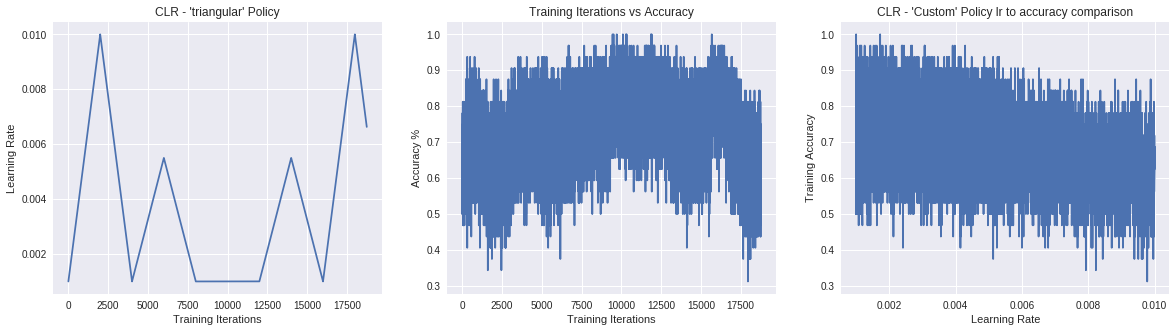

In [0]:
# image size 64x64: Fit the model on the batches generated by datagen.flow()

from math import ceil

batch_size = 32

train_generator_64 = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=batch_size, class_mode='categorical', shuffle=True, seed=42)
validation_generator_64 = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42)

filepath_64 = model_path + "try-3-saved-model-woa-64-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint_64 = ModelCheckpoint(filepath_64, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(train_generator_64,
                    steps_per_epoch=train_generator_64.n/batch_size,
                    validation_data=validation_generator_64,
                    validation_steps=ceil(validation_generator_64.n/batch_size),
                    epochs=100, verbose=1, initial_epoch=94,
                    callbacks=[clr, checkpoint_64])

model.save(model_path + 'try-3-saved-model-woa-64.h5')  # creates a HDF5 file

plt.rcParams["figure.figsize"] = (20, 5)

plt.subplot(1, 3, 1)
plt.plot(clr.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")

plt.subplot(1, 3, 2)
plt.plot(clr.history['iterations'], clr.history['acc'])
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy %')
plt.title("Training Iterations vs Accuracy")

plt.subplot(1, 3, 3)
plt.plot(clr.history['lr'], clr.history['acc'])
plt.xlabel('Learning Rate')
plt.ylabel('Training Accuracy')
plt.title("CLR - 'Custom' Policy lr to accuracy comparison")

plt.show()

## Train With Augumentation

In [0]:
# @title Create Image Augumentation
train_datagen = ImageDataGenerator(rotation_range=30,
                                   rescale= 1./255,
                                   # width_shift_range=0.2,
                                   # height_shift_range=0.2,
                                   # shear_range=0.01,
                                   zoom_range=[0.9, 1.25],
                                   horizontal_flip=True,
                                   # vertical_flip=False,
                                   # fill_mode='reflect',
                                   brightness_range=[0.5, 1.5]
)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
# @title Initialize CLRs
base_lr = 0.001
max_lr = 0.005
step_size = 200
scale_mode = 'cycle'

clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
clr = CyclicLR(base_lr=base_lr, max_lr=max_lr,
               step_size=step_size, scale_fn=clr_fn,
               scale_mode=scale_mode)

print("Clr Parameters")
print("LR Range", max_lr, "-", base_lr)
print("Step Size", step_size)
print("Mode", scale_mode)

Clr Parameters
LR Range 0.005 - 0.001
Step Size 200
Mode cycle


### Load Model

In [0]:
from keras.models import load_model
# identical to the previous one
model = load_model('/content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-64-97-0.53.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Retrain the Model

In [0]:
# image size 32x32: Fit the model on the batches generated by datagen.flow()

from math import ceil

batch_size = 128

train_generator_32 = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(32, 32), color_mode='rgb', 
                                                    batch_size=batch_size, class_mode='categorical', shuffle=True, seed=42)
validation_generator_32 = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(32, 32),
                                                    color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42)

filepath_32 = model_path + "try-3-saved-model-wa-32-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint_32 = ModelCheckpoint(filepath_32, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(train_generator_32,
                    steps_per_epoch=train_generator_32.n/batch_size,
                    validation_data=validation_generator_32,
                    validation_steps=ceil(validation_generator_32.n/batch_size),
                    epochs=120, verbose=1, initial_epoch=100,
                    callbacks=[clr, checkpoint_32])

model.save(model_path + 'try-3-saved-model-wa-32.h5')  # creates a HDF5 file

plt.rcParams["figure.figsize"] = (20, 5)

plt.subplot(1, 3, 1)
plt.plot(clr.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")

plt.subplot(1, 3, 2)
plt.plot(clr.history['iterations'], clr.history['acc'])
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy %')
plt.title("Training Iterations vs Accuracy")

plt.subplot(1, 3, 3)
plt.plot(clr.history['lr'], clr.history['acc'])
plt.xlabel('Learning Rate')
plt.ylabel('Training Accuracy')
plt.title("CLR - 'Custom' Policy lr to accuracy comparison")

plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 101/120
782/781 [==============================] - 665s 851ms/step - loss: 3.6523 - acc: 0.2704 - val_loss: 3.6335 - val_acc: 0.2721

Epoch 00101: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-wa-32-101-0.27.hdf5
Epoch 102/120
782/781 [==============================] - 663s 848ms/step - loss: 2.9786 - acc: 0.3154 - val_loss: 3.4690 - val_acc: 0.2824

Epoch 00102: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-wa-32-102-0.28.hdf5
Epoch 103/120
782/781 [==============================] - 666s 852ms/step - loss: 2.8249 - acc: 0.3388 - val_loss: 3.2942 - val_acc: 0.3038

Epoch 00103: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-wa-32-103-0.30.hdf5
Epoch 104/120
782/781 [==============================] - 662s 847ms/step - loss: 2.7026 - acc: 0.3602 - val_loss: 3.4385 - val_acc: 0.2898

Epoch 0

### Loal the model

In [0]:
from keras.models import load_model
# identical to the previous one
model = load_model('/content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-wa-32-116-0.35.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Retrain the model

In [0]:
# image size 64x64: Fit the model on the batches generated by datagen.flow()

from math import ceil

batch_size = 32

train_generator_64 = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=batch_size, class_mode='categorical', shuffle=True, seed=42)
validation_generator_64 = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42)

filepath_64 = model_path + "try-3-saved-model-wa-64-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint_64 = ModelCheckpoint(filepath_64, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(train_generator_64,
                    steps_per_epoch=train_generator_64.n/batch_size,
                    validation_data=validation_generator_64,
                    validation_steps=ceil(validation_generator_64.n/batch_size),
                    epochs=120, verbose=1, initial_epoch=100,
                    callbacks=[clr, checkpoint_64])

model.save(model_path + 'try-3-saved-model-wa-64.h5')  # creates a HDF5 file

plt.rcParams["figure.figsize"] = (20, 5)

plt.subplot(1, 3, 1)
plt.plot(clr.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")

plt.subplot(1, 3, 2)
plt.plot(clr.history['iterations'], clr.history['acc'])
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy %')
plt.title("Training Iterations vs Accuracy")

plt.subplot(1, 3, 3)
plt.plot(clr.history['lr'], clr.history['acc'])
plt.xlabel('Learning Rate')
plt.ylabel('Training Accuracy')
plt.title("CLR - 'Custom' Policy lr to accuracy comparison")

plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 101/120
3125/3125 [==============================] - 5061s 2s/step - loss: 1.9054 - acc: 0.5186 - val_loss: 2.4722 - val_acc: 0.4382

Epoch 00101: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-wa-64-101-0.44.hdf5
Epoch 102/120
3125/3125 [==============================] - 5042s 2s/step - loss: 1.7697 - acc: 0.5501 - val_loss: 2.4774 - val_acc: 0.4471

Epoch 00102: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-wa-64-102-0.45.hdf5
Epoch 103/120
3125/3125 [==============================] - 5043s 2s/step - loss: 1.7293 - acc: 0.5569 - val_loss: 2.5316 - val_acc: 0.4459

Epoch 00103: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-wa-64-103-0.45.hdf5
Epoch 104/120
3125/3125 [==============================] - 5034s 2s/step - loss: 1.6998 - acc: 0.5658 - val_loss: 2.4517 - val_acc: 0.4537

Epoch 0

### Load Model

In [0]:
from keras.models import load_model
# identical to the previous one
model = load_model('/content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-woa-64-97-0.53.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Retrain Model

In [0]:
# image size 64x64: Fit the model on the batches generated by datagen.flow()

from math import ceil

batch_size = 32

train_generator_64 = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=batch_size, class_mode='categorical', shuffle=True, seed=42)
validation_generator_64 = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42)

filepath_64 = model_path + "try-3-saved-model-wa-64-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint_64 = ModelCheckpoint(filepath_64, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(train_generator_64,
                    steps_per_epoch=train_generator_64.n/batch_size,
                    validation_data=validation_generator_64,
                    validation_steps=ceil(validation_generator_64.n/batch_size),
                    epochs=120, verbose=1, initial_epoch=110,
                    callbacks=[clr, checkpoint_64])

model.save(model_path + 'try-3-saved-model-wa-64.h5')  # creates a HDF5 file

plt.rcParams["figure.figsize"] = (20, 5)

plt.subplot(1, 3, 1)
plt.plot(clr.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")

plt.subplot(1, 3, 2)
plt.plot(clr.history['iterations'], clr.history['acc'])
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy %')
plt.title("Training Iterations vs Accuracy")

plt.subplot(1, 3, 3)
plt.plot(clr.history['lr'], clr.history['acc'])
plt.xlabel('Learning Rate')
plt.ylabel('Training Accuracy')
plt.title("CLR - 'Custom' Policy lr to accuracy comparison")

plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 111/120
3125/3125 [==============================] - 5027s 2s/step - loss: 2.0519 - acc: 0.4937 - val_loss: 2.7138 - val_acc: 0.4217

Epoch 00111: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-wa-64-111-0.42.hdf5
Epoch 112/120
3125/3125 [==============================] - 4989s 2s/step - loss: 1.8837 - acc: 0.5243 - val_loss: 2.6215 - val_acc: 0.4360

Epoch 00112: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-wa-64-112-0.44.hdf5
Epoch 113/120
3125/3125 [==============================] - 5018s 2s/step - loss: 1.8321 - acc: 0.5352 - val_loss: 2.6620 - val_acc: 0.4302

Epoch 00113: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-wa-64-113-0.43.hdf5
Epoch 114/120
3125/3125 [==============================] - 4989s 2s/step - loss: 1.7910 - acc: 0.5465 - val_loss: 2.6050 - val_acc: 0.4379

Epoch 0

### Load Model

In [0]:
from keras.models import load_model
# identical to the previous one
model = load_model('/content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-wa-64-118-0.46.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Retrain Model

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 119/120
3125/3125 [==============================] - 5117s 2s/step - loss: 1.6913 - acc: 0.5661 - val_loss: 2.5873 - val_acc: 0.4387

Epoch 00119: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-wa-64-119-0.44.hdf5
Epoch 120/120
3125/3125 [==============================] - 5091s 2s/step - loss: 1.6739 - acc: 0.5693 - val_loss: 2.6301 - val_acc: 0.4358

Epoch 00120: saving model to /content/gdrive/My Drive/models/densenet/try_3/try-3-saved-model-wa-64-120-0.44.hdf5


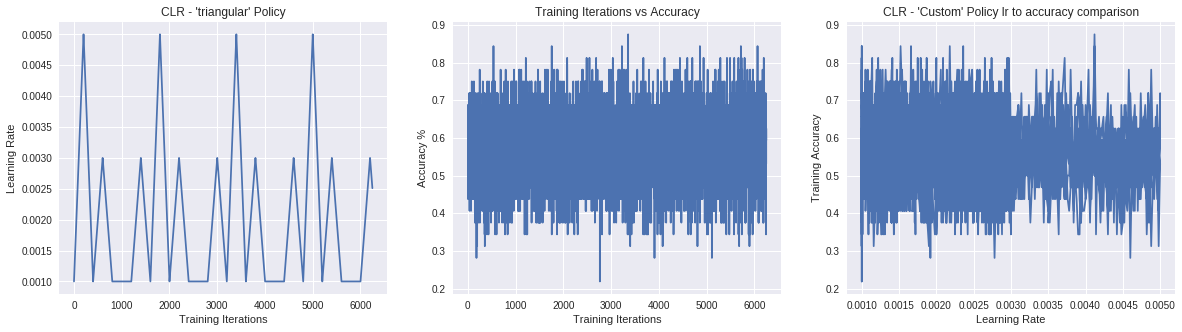

In [0]:
# image size 64x64: Fit the model on the batches generated by datagen.flow()

from math import ceil

batch_size = 32

train_generator_64 = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=batch_size, class_mode='categorical', shuffle=True, seed=42)
validation_generator_64 = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42)

filepath_64 = model_path + "try-3-saved-model-wa-64-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint_64 = ModelCheckpoint(filepath_64, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(train_generator_64,
                    steps_per_epoch=train_generator_64.n/batch_size,
                    validation_data=validation_generator_64,
                    validation_steps=ceil(validation_generator_64.n/batch_size),
                    epochs=120, verbose=1, initial_epoch=118,
                    callbacks=[clr, checkpoint_64])

model.save(model_path + 'try-3-saved-model-wa-64.h5')  # creates a HDF5 file

plt.rcParams["figure.figsize"] = (20, 5)

plt.subplot(1, 3, 1)
plt.plot(clr.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")

plt.subplot(1, 3, 2)
plt.plot(clr.history['iterations'], clr.history['acc'])
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy %')
plt.title("Training Iterations vs Accuracy")

plt.subplot(1, 3, 3)
plt.plot(clr.history['lr'], clr.history['acc'])
plt.xlabel('Learning Rate')
plt.ylabel('Training Accuracy')
plt.title("CLR - 'Custom' Policy lr to accuracy comparison")

plt.show()

## Confusion Matrix

In [0]:
# Import sklearn confusion matrix creator
from sklearn.metrics import confusion_matrix


valid_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=10000, shuffle=False)

# Reset the index to start index (0)
validation_generator.reset()

# Predict model
predictions = model.predict_generator(validation_generator, verbose=1)


predicted_class_indices = np.argmax(predictions, axis=1)
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

# Reset the index to start index (0)
validation_generator.reset()
